In [1]:
import pandas as pd
import numpy as np
from random import randint
from newspaper import Article
import re
import matplotlib.pyplot as plt
import pydot
from networkx.drawing.nx_pydot import graphviz_layout

from urllib.parse import urlparse
from bs4 import BeautifulSoup
import requests
import networkx as nx
from scipy.linalg import null_space
import scipy

In [2]:
all_news = pd.read_csv("../data/all_news.csv")
selected_news = pd.read_csv("../data/selected_articles.csv")

In [3]:
len(all_news)

51145

In [4]:
len(selected_news)

983

In [3]:
def get_external_links(url):
    domain_name = urlparse(url).netloc

    if domain_name == 't.co':
        domain_name = 'twitter'
        
    soup = BeautifulSoup(requests.get(url).content)
    text = soup.findAll('p')

    external_links = [a.attrs.get('href') for article in text for a in article.findAll('a', href=True) if domain_name not in a.attrs.get('href') and a.attrs.get('href')[0:5] == 'https']
    return external_links, domain_name

In [4]:
def add_to_adjacency_m(level, num_links, nodes, max_depth):
     # create adjacency matrix
    if (len(nodes) == 0):
        nodes.append(np.array(np.append(0, np.repeat(1, num_links))))
    else:
        prev = nodes[-1]
        children = np.repeat(1, num_links)
        if (level == max_depth):
            children = np.array([])
        insert_nodes = np.array(np.insert(np.repeat(0, len(prev)), len(prev), children))
        
        # reshape previous nodes to account for new nodes
        for i in range(0, len(nodes)):
            if (len(nodes[i]) == len(insert_nodes)):
                break
            nodes[i] = np.array(np.insert(nodes[i], len(nodes[i]), np.repeat(0, len(children))))

        nodes.append(insert_nodes)

In [128]:
MAX_DEPTH = 3
def find_source(url, level, all_sources, nodes, all_links):
    all_links.append(url)
    # get external links
    links = []
    try:
        links, domain_name = get_external_links(url)
    except Exception as e:
        print(e)
        pass

    # creates adjacency matrix from recursive function
    add_to_adjacency_m(level, len(links), nodes, MAX_DEPTH)

    # link is a source if it has no external links (base case)
    if (len(links) == 0):
        all_sources.append(url)
        return
    # depth limit base case
    if (level >= MAX_DEPTH):
        return
    # explore all external links
    level += 1
    for link in links:
        find_source(link, level, all_sources, nodes, all_links)

### This daily caller source has a really large tree 

In [196]:
sub = all_news[all_news.url.str.contains("dailycaller")]
# these two sources don't seem to be very credible and create a big tree
test_url = sub[sub.title.str.contains("Rapino")].url.values[0]
test_url2 = 'http://www.womensystems.com/2021/08/chris-cuomo-defied-cnn-ban-on-advising.html'
# this source is interesting because it has another article on the same page that sends you down a rabbit hole related to that topic
test_url3 = 'https://www.axios.com/spacex-launches-inspiration4-mission-civilians-b87c68da-dee8-4671-927b-a7d7d8f1c4d5.html'

# this is a politically charged topic that produces a big tree about COVID-19
test_url4 = 'https://www.huffpost.com/entry/bob-enyart-coronavirus-death-right-wing-radio-host_n_613fffcbe4b0dda4cbd2b3a4'
# saved adjacency matrix and links
A4 = np.loadtxt("adj_matrix.txt", delimiter=',')
links4 = pd.read_csv("links.csv")

In [197]:
# trying random sample
test_url = selected_news.sample(1).url.values[0]
test_url

'https://finance.yahoo.com/news/india-biopower-analysis-market-outlook-170000326.html'

In [198]:
level = 0
sources = []
all_nodes = []
all_articles = []
find_source(test_url, level, sources, all_nodes, all_articles)

### Visualizing source structure

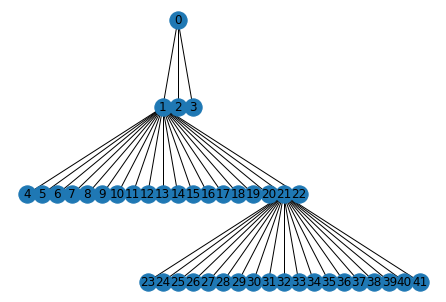

In [199]:
A = np.array(all_nodes)
G = nx.Graph(A)
pos = graphviz_layout(G, prog="dot")
nx.draw(G, pos, with_labels=True)

In [200]:
# The only connected components are the internal nodes
ns = null_space(A)
ns.shape

(42, 39)

In [201]:
col_space = scipy.linalg.orth(A)
col_space.shape

(42, 3)

## Seeing the difference in the keywords of the original and the keywords of the sources

In [184]:
print(len(sources))
print(len(all_articles))

325
641


In [134]:
source_keywords = []
for source in sources:
    if ("t.co" in source) or ("twitter" in source) or ("instagram" in source):
        continue
    else:
        try:
            article = Article(source)
            article.download()
            article.parse()
            article.nlp()
            source_keywords.append(article.keywords)
        except:
            source_keywords.append([])

In [165]:
article = Article(test_url)
article.download()
article.parse()
article.nlp()
orginal_keywords = article.keywords

In [166]:
orginal_keywords

['mask',
 'coronavirus',
 'aids',
 'shot',
 'antivax',
 'rightwing',
 'opposed',
 'radio',
 'host',
 'covid19',
 'refused',
 'enyart',
 'mandates',
 'mocked',
 'dies',
 'victims',
 'vaccine']

In [137]:
source_keywords

[['happened',
  'vice',
  'white',
  'trumps',
  'president',
  'reporting',
  'swan',
  'zach',
  'trump',
  'political',
  'series'],
 ['continue', 'facebook', 'log', 'noticeyou'],
 ['happenplease',
  'loading',
  'supports',
  'sure',
  'service',
  'information',
  'javascript',
  'review',
  'robot',
  'terms',
  'policy'],
 [],
 ['ceiling',
  'house',
  'fiscal',
  'administration',
  'cuts',
  'fights',
  'republicans',
  'used',
  'labeled',
  'debt',
  'obama',
  'white'],
 ['states',
  'coins',
  'pub',
  'design',
  'shall',
  'finance',
  'secretary',
  'issued',
  'coin',
  'l',
  'money',
  'subsection'],
 ['treasury',
  'yellen',
  'possibility',
  'house',
  'white',
  'chatter',
  'president',
  '14th',
  'lawmakers',
  'narrowing',
  'returns',
  'debt',
  'options',
  'limit',
  'default',
  'amendment'],
 ['states',
  'remains',
  'poll',
  'plan',
  'spending',
  'agenda',
  'support',
  'voters',
  'key',
  'supported',
  'members',
  'popular',
  'better',
  'dis